In [1]:
# TODO: z_d, z_nucleosynthesis
# TODO: non-gaussian and covariant likelihoods

import numpy as np
import emcee
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import corner
from IPython.display import display, Math
import pandas as pd
import scipy

In [2]:
#------ BACKGROUND EQUATIONS ------

# Equation 2.14
def Omega_Lambda(cosmo):
    Omega_c , Omega_b , Omega_k , Omega_r, alpha_tilde, C_t = cosmo
    Omega_m = Omega_c + Omega_b
    
    return 1 - Omega_m - Omega_r - Omega_k + alpha_tilde * (1 - C_t**2 + Omega_k**2 - 2*Omega_k)

# Equation 2.13
def X(z, cosmo):
    
    Omega_c , Omega_b , Omega_k , Omega_r, alpha_tilde, C_t = cosmo
    Omega_m = Omega_c + Omega_b
    Omega_lambda = Omega_Lambda(cosmo)
    
    return 1 + 4 * alpha_tilde * (Omega_m * (1 + z) ** 3 + (Omega_r + alpha_tilde*C_t**2) * (1 + z)** 4 + Omega_lambda)

# Equation 2.12
def E(z , cosmo):
    
    Omega_c , Omega_b , Omega_k , Omega_r, alpha_tilde, C_t = cosmo
    Omega_m = Omega_c + Omega_b
    Omega_lambda = Omega_Lambda(cosmo)
    
    E_L = Omega_m * (1 + z) ** 3 + (Omega_r + alpha_tilde*C_t**2) * (1 + z) ** 4 + Omega_k * (1 + z) ** 2 + Omega_lambda
    
    if alpha_tilde == 0:
        ans = np.sqrt(E_L + Omega_k * (1 + z) ** 2)
    
    # small alpha approximation to deal with numerical instabilities
    elif alpha_tilde < 1e-10 and E_L < 1e4:
        ans = np.sqrt(E_L + Omega_k * (1 + z) ** 2 - alpha_tilde* (E_L**2)/4)
    
    else:
        ans = np.sqrt((np.sqrt(X(z , cosmo)) - 1 + (2 * alpha_tilde * Omega_k * (1+z) ** 2))/(2 * alpha_tilde))
    
    return ans


In [19]:
# ------ equations for BAO ------ c = 1

# Angular diameter distance
def D_M_H0(z,cosmo):
    Omega_c , Omega_b , Omega_k , Omega_r , alpha_tilde, C_t = cosmo
    Omega_m = Omega_c + Omega_b
    Omega_lambda = Omega_Lambda(cosmo)

    D = np.zeros(len(z))
    for i in range(len(z)):
        chi = scipy.integrate.quad(lambda x: 1/E(x,cosmo), 0 , z[i])[0]
        if Omega_k > 0:
            D[i] = np.sinh(np.sqrt(Omega_k)*chi)/np.sqrt(Omega_k)
        elif Omega_k < 0:
            D[i] = np.sin(np.sqrt(Omega_k)*chi)/np.sqrt(Omega_k)
        else:
            D[i] = chi
    return D

# Hubble distance
def D_H_H0(z,cosmo):
    D = np.zeros(len(z))
    for i in range(len(z)):
        D[i] = 1/E(z[i],cosmo)
    return D

# Spherically-averaged distance (historical BAO distance)
def D_V_H0(z,cosmo):
    return (z*D_H_H0(z,cosmo)*D_M_H0(z,cosmo)**2)**(1/3)

# redshift at drag epoch - for now assume a LCDM constant
# See https://arxiv.org/pdf/1306.3208.pdf Appendix B to find value exactly at a given parameter (this is quite involved) 
def z_d():
    return 1020.5

# Used to find r_s - only works for 0.0025 < wb < 0.25 and 0.025 < wm < 0.64 
def R_b(wb):
    return 31500*wb*(2.7255/2.7)**(-4)

# Note that we assumed sound horizon was zero at the end of nucleosynthesis
def r_d_H0(cosmo,h):
    Omega_c , Omega_b , Omega_k , Omega_r , alpha_tilde, C_t = cosmo
    Omega_m = Omega_c + Omega_b
    
    return scipy.integrate.quad(lambda x: 1/((x**2)*E(1/x -1, cosmo)*np.sqrt(3*(1 + R_b(Omega_b*h**2)*x))), 2.5e-9, 1/(1+z_d()))[0]

In [20]:
def log_likelihood_DV(theta, z, y, yerr):
    # note: c in km/s, H in km/s/Mpc and D_A in Mpc
    
    Omg_c, h, alpha_t = theta 
    Omg_b = 0.05 
    
    Omg_r = (2.47e-5*h**-2)*1.6949484 # last factor due to neutrinos
    model = D_V_H0(z,[Omg_c , Omg_b , 0 , Omg_r , alpha_t,0])/r_d_H0([Omg_c , Omg_b , 0 , Omg_r , alpha_t,0],h)
    
    return -0.5 * np.matmul(np.matmul((y-model),np.linalg.inv(yerr)),np.transpose(y-model))

In [21]:
def log_likelihood_DM(theta, z, y, yerr):
    # note: c in km/s, H in km/s/Mpc and D_A in Mpc
    
    Omg_c, h, alpha_t = theta 
    Omg_b = 0.05 
    
    Omg_r = (2.47e-5*h**-2)*1.6949484 # last factor due to neutrinos
    model = D_M_H0(z,[Omg_c, Omg_b , 0 , Omg_r , alpha_t,0])/r_d_H0([Omg_c, Omg_b , 0 , Omg_r , alpha_t,0],h)
    return -0.5 * np.matmul(np.matmul((y-model),np.linalg.inv(yerr)),np.transpose(y-model))

In [22]:
def log_likelihood_DH(theta, z, y, yerr):
    # note: c in km/s, H in km/s/Mpc and D_A in Mpc
    # note: log likelihood = -chi^2/2
    Omg_c, h, alpha_t = theta 
    Omg_b = 0.05 

    Omg_r = (2.47e-5*h**-2)*1.6949484 # last factor due to neutrinos
    model = D_H_H0(z,[Omg_c, Omg_b , 0 , Omg_r , alpha_t,0])/r_d_H0([Omg_c, Omg_b , 0 , Omg_r , alpha_t,0],h)
    return -0.5 * np.matmul(np.matmul((y-model),np.linalg.inv(yerr)),np.transpose(y-model))

In [23]:
def log_prior(theta):
    Omg_c, h, alpha_t = theta 
    Omg_b = 0.05 

    wb = Omg_b*h**2
    wm = (Omg_c + Omg_b)*h**2
    if 0.025 < wm < 0.64 and 0 < h < 1 and -1e-50 < alpha_t < 1 :
        return 0.0
    return -np.inf

In [24]:
def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    x_v, x_m, x_h = x
    y_v, y_m, y_h = y
    yerr_v, yerr_m, yerr_h = yerr
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_DV(theta, x_v, y_v, yerr_v) + log_likelihood_DM(theta, x_m, y_m, yerr_m)\
            + log_likelihood_DH(theta, x_h, y_h, yerr_h)

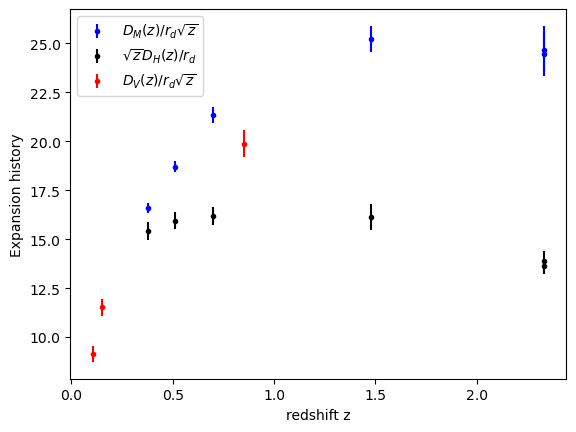

In [25]:
#get the data

# Choose the "true" parameters.
Omg_c_est = 0.3
h_est = 0.5
alpha_t_est = 0.01
# BOSS Galaxy, eBOSS LRG, eBOSS Quasar =, Ly\alpha-Ly\alpha and Ly\alpha-Quasar data
x_D_mh_over_rd = np.array([0.38,0.51,0.70,1.48,2.33,2.33])

y_D_m_over_rd = np.array([10.23,13.36,17.86,30.69,37.6,37.3])
yerr_D_m_over_rd =np.diag([0.17,0.21,0.33,0.8,1.9,1.7])

y_D_h_over_rd = np.array([25,22.33,19.33,13.26,8.93,9.08])
yerr_D_h_over_rd =np.diag([0.76,0.58,0.53,0.55,0.28,0.34])

# eBOSS ELG data
x_ELG = 0.85
y_ELG_Dv_over_rd = 18.33
yerr_ELG_Dv_over_rd = 0.62 # TODO how do you account for different max/min?

# 6dFGS and MGS data
x_6dFGS = 0.106
y_6dFGS_Dv_over_rd = 1/0.336
yerr_6dFGS_Dv_over_rd = 0.015/0.336**2

rd_fid = 148.69
x_MGS = 0.15
y_MGS_Dv_over_rd = 664 / rd_fid
yerr_MGS_Dv_over_rd = 25 / rd_fid # TODO check

# Combine data
x = [np.array([x_ELG,x_6dFGS,x_MGS]),x_D_mh_over_rd,x_D_mh_over_rd]
y = [np.array([y_ELG_Dv_over_rd,y_6dFGS_Dv_over_rd,y_MGS_Dv_over_rd]),y_D_m_over_rd,y_D_h_over_rd]
sigma = [np.diag([yerr_ELG_Dv_over_rd**2,yerr_6dFGS_Dv_over_rd**2,yerr_MGS_Dv_over_rd**2]) , yerr_D_m_over_rd**2 , yerr_D_h_over_rd**2]

# Plot our data
plt.errorbar(x_D_mh_over_rd, y_D_m_over_rd/np.sqrt(x_D_mh_over_rd), yerr=np.diag(yerr_D_m_over_rd/np.sqrt(x_D_mh_over_rd)), fmt=".b", capsize=0, label = r"$D_M(z)/r_d\sqrt{z}$")
plt.errorbar(x_D_mh_over_rd, y_D_h_over_rd*np.sqrt(x_D_mh_over_rd), yerr=np.diag(yerr_D_h_over_rd)*np.sqrt(x_D_mh_over_rd), fmt=".k", capsize=0, label = r"$\sqrt{z}D_H(z)/r_d$")

plt.errorbar([x_6dFGS,x_MGS,x_ELG], [y_6dFGS_Dv_over_rd/np.sqrt(x_6dFGS), y_MGS_Dv_over_rd/np.sqrt(x_MGS), y_ELG_Dv_over_rd/np.sqrt(x_ELG)],\
             yerr=[yerr_6dFGS_Dv_over_rd/np.sqrt(x_6dFGS), yerr_MGS_Dv_over_rd/np.sqrt(x_MGS), yerr_ELG_Dv_over_rd/np.sqrt(x_ELG)], fmt=".r", capsize=0, label = r"$D_V(z)/r_d\sqrt{z}$")
plt.legend()
x0 = np.linspace(0, 10, 500)
plt.xlabel("redshift z")
plt.ylabel("Expansion history");

In [35]:
#MCMC method

# initializing the walkers in a tiny Gaussian ball around the maximum likelihood result
#and then run 10,000 steps of MCMC
pos = [Omg_c_est , h_est, alpha_t_est] + 1e-4 * np.random.randn(50, 3)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(x, y, sigma)
)
sampler.run_mcmc(pos, 5000, progress=True);

  3%|█▎                                      | 164/5000 [01:45<49:43,  1.62it/s]/tmp/ipykernel_399635/1222874594.py:11: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  chi = scipy.integrate.quad(lambda x: 1/E(x,cosmo), 0 , z[i])[0]
100%|███████████████████████████████████████| 5000/5000 [55:42<00:00,  1.50it/s]


(14300, 3)


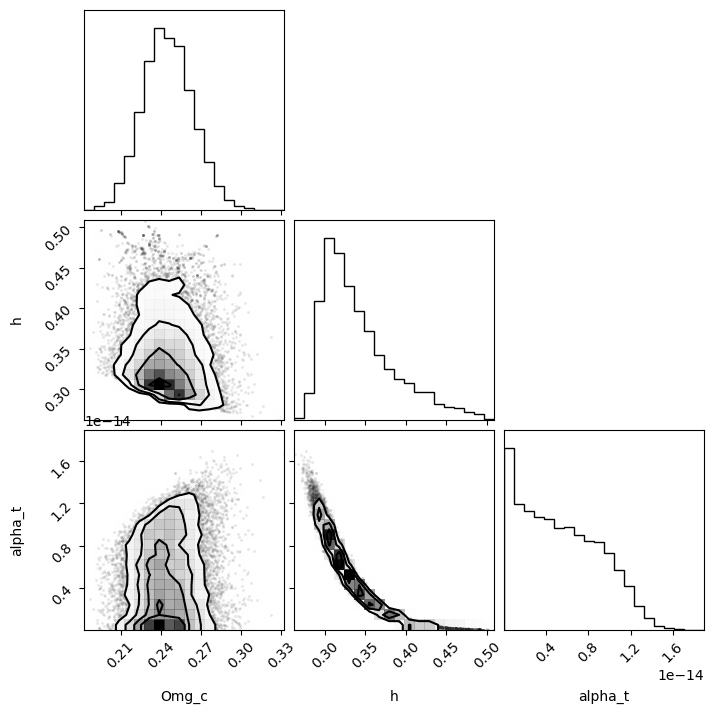

In [40]:
flat_samples = sampler.get_chain(discard=700, thin=15, flat=True)
labels = ["Omg_c", "h", "alpha_t"]
print(flat_samples.shape)

fig = corner.corner(
    flat_samples, labels=labels
);

50
5000
3
5000


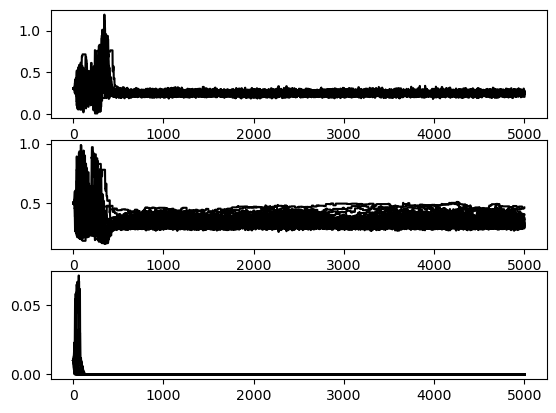

In [37]:
samples_chain = sampler.chain
print(len(samples_chain))
print(len(samples_chain[0]))
print(len(samples_chain[0][0]))
print(len(samples_chain[0, :, 0]))

fig, ax = plt.subplots(3)

for i in range(len(samples_chain)):
    ax[0].plot(samples_chain[i, :, 0], color = "black")
    ax[1].plot(samples_chain[i, :, 1], color = "black")
    ax[2].plot(samples_chain[i, :, 2], color = "black")


In [38]:
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.15f}_{{-{1:.15f}}}^{{{2:.15f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

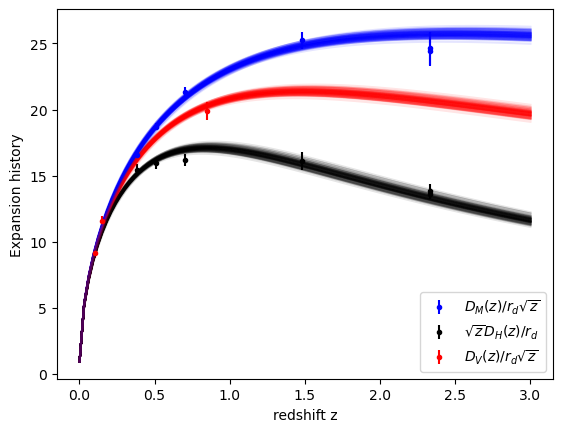

In [39]:
# --- PLOT DATA WITH ESTIMATED PARAMS -----

# data
plt.errorbar(x_D_mh_over_rd, y_D_m_over_rd/np.sqrt(x_D_mh_over_rd), yerr=np.diag(yerr_D_m_over_rd/np.sqrt(x_D_mh_over_rd)), fmt=".b", capsize=0, label = r"$D_M(z)/r_d\sqrt{z}$")
plt.errorbar(x_D_mh_over_rd, y_D_h_over_rd*np.sqrt(x_D_mh_over_rd), yerr=np.diag(yerr_D_h_over_rd)*np.sqrt(x_D_mh_over_rd), fmt=".k", capsize=0, label = r"$\sqrt{z}D_H(z)/r_d$")

plt.errorbar([x_6dFGS,x_MGS,x_ELG], [y_6dFGS_Dv_over_rd/np.sqrt(x_6dFGS), y_MGS_Dv_over_rd/np.sqrt(x_MGS), y_ELG_Dv_over_rd/np.sqrt(x_ELG)],\
             yerr=[yerr_6dFGS_Dv_over_rd/np.sqrt(x_6dFGS), yerr_MGS_Dv_over_rd/np.sqrt(x_MGS), yerr_ELG_Dv_over_rd/np.sqrt(x_ELG)], fmt=".r", capsize=0, label = r"$D_V(z)/r_d\sqrt{z}$")
plt.legend()
plt.xlabel("redshift z")
plt.ylabel("Expansion history");


xl = np.linspace(0.001,3,int(1e2))
for Omg_c, h, alpha_t in flat_samples[np.random.randint(len(flat_samples), size=100)]:
    Omg_r = (2.47e-5*h**-2)*1.6949484 
    plt.plot(xl, np.sqrt(xl)*D_H_H0(xl,[Omg_c , 0.05 , 0 , Omg_r , alpha_t , 0])/r_d_H0([Omg_c , 0.05 , 0 , Omg_r , alpha_t , 0],h), color="k", alpha=0.1)
    plt.plot(xl, D_V_H0(xl,[Omg_c , 0.05 , 0 , Omg_r , alpha_t , 0])/(r_d_H0([Omg_c , 0.05 , 0 , Omg_r , alpha_t , 0],h)*np.sqrt(xl)), color="r", alpha=0.1)
    plt.plot(xl, D_M_H0(xl,[Omg_c , 0.05 , 0 , Omg_r , alpha_t , 0])/(r_d_H0([Omg_c , 0.05 , 0 , Omg_r , alpha_t , 0],h)*np.sqrt(xl)), color="b", alpha=0.1)
